In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [265]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

In [106]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv") 
#read data

In [107]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Clean data

In [108]:
#log transform the target:
y=list(train['SalePrice'])
y = np.log1p(y)
all_data = pd.concat((train,
                      test)).drop(['SalePrice','Id'],axis = 1)
#combine both data set to clean data

In [109]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str).astype(object)
#MSSubClass should be a categorical column

In [110]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [111]:
skewed_feats

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea',
       'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'WoodDeckSF'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACEBE780B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001ACED6EEC50>]], dtype=object)

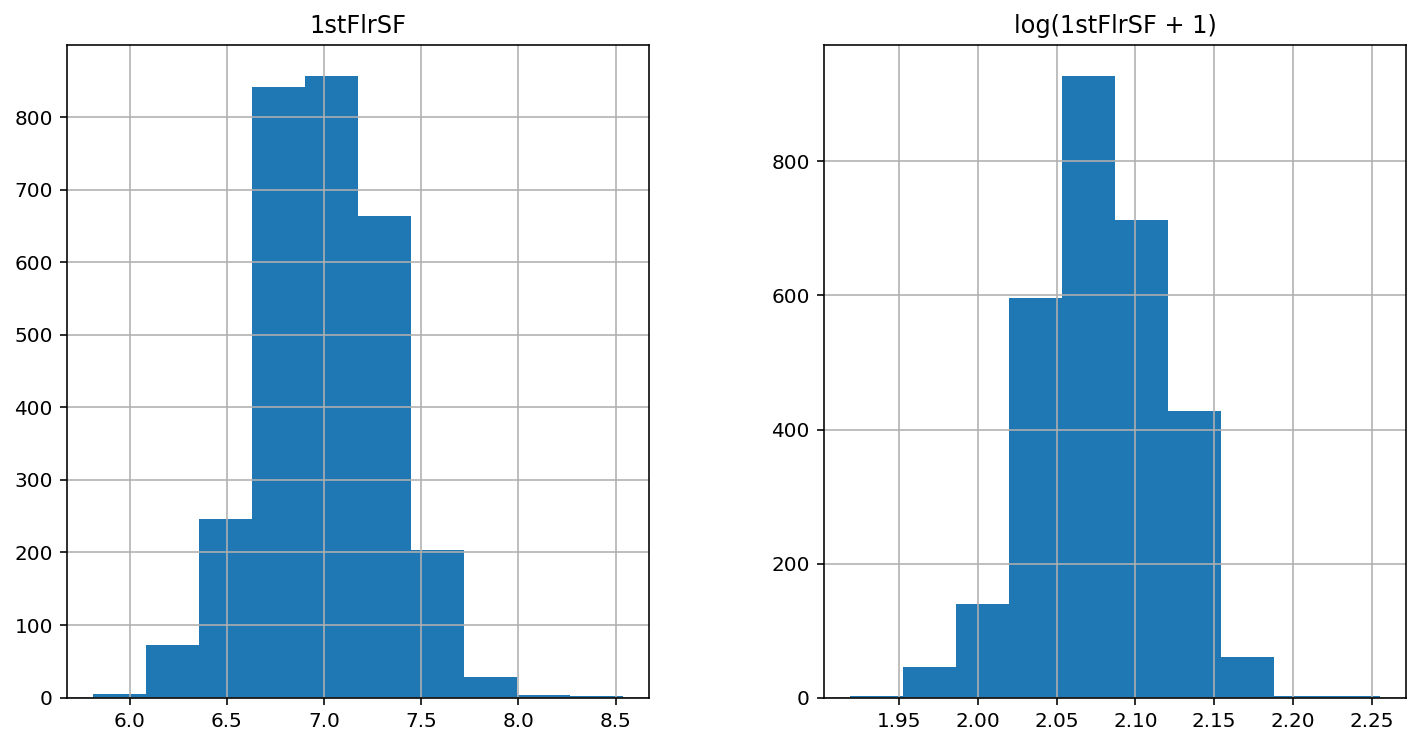

In [112]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
PoolAreas = pd.DataFrame({"1stFlrSF":all_data["1stFlrSF"], "log(1stFlrSF + 1)":np.log1p(all_data["1stFlrSF"])})
PoolAreas.hist()

In [113]:
Dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
             "Mn": 2, "Av": 3, 
             "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
             "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8,
             "RFn": 2, "Fin": 3,
             "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
             "N": 0, "Y": 1, np.nan:0
            }

for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
          'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
          'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 
          'CentralAir']:

        all_data[col] = all_data[col].map(Dict).astype(int)

In [114]:
all_data = all_data.fillna({
    'Alley' : 'NoAlley',
    'MasVnrType': 'None',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'BsmtQual' : 'NoBsmt',
    'BsmtCond' : 'NoBsmt',
    'BsmtExposure' : 'NoBsmt',
    'BsmtFinType1' : 'NoBsmt',
    'BsmtFinType2' : 'NoBsmt',
    'KitchenQual' : 'TA',
    'MSZoning' : 'RL',
    'Utilities' : 'AllPub',
    'Exterior1st' : 'VinylSd',
    'Exterior2nd'   : 'VinylSd',
    'Functional' : 'Typ',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'Electrical' : 'SBrkr'
     
})


all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0

all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()






# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

In [115]:
#drop predictor according to Shu's code
all_data = all_data.drop(['Street','Utilities','Condition2','RoofMatl',
                         'LowQualFinSF','3SsnPorch','PoolArea','PoolQC','MiscVal','GarageYrBlt'],axis = 1)

In [116]:
#warnings.simplefilter('ignore', np.RankWarning)
# I have no idea how to do it better. Probably, it is better to do nothing
a1 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
a2 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (a1 <= 25000) & (a2 <= 150)
p = np.polyfit(a1[t], a2[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

In [117]:
all_data['BsmtFinSF2'].fillna(0,inplace = True)
all_data['TotalBsmtSF'].fillna(0,inplace = True)
# all_data.isnull().sum()  TotalBsmtSF

In [118]:
all_data.isnull().any()

1stFlrSF         False
2ndFlrSF         False
Alley            False
BedroomAbvGr     False
BldgType         False
BsmtCond         False
BsmtExposure     False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtFinType1     False
BsmtFinType2     False
BsmtFullBath     False
BsmtHalfBath     False
BsmtQual         False
BsmtUnfSF        False
CentralAir       False
Condition1       False
Electrical       False
EnclosedPorch    False
ExterCond        False
ExterQual        False
Exterior1st      False
Exterior2nd      False
Fence            False
FireplaceQu      False
Fireplaces       False
Foundation       False
FullBath         False
Functional       False
GarageArea       False
                 ...  
HouseStyle       False
KitchenAbvGr     False
KitchenQual      False
LandContour      False
LandSlope        False
LotArea          False
LotConfig        False
LotFrontage      False
LotShape         False
MSSubClass       False
MSZoning         False
MasVnrArea       False
MasVnrType 

In [119]:
np.isfinite(all_data).any()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [120]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Electrical', 'EnclosedPorch', 'ExterCond',
       'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu',
       'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
       'LotConfig', 'LotFrontage', 'LotShape', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'RoofStyle',
       'SaleCondition', 'SaleType', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'W

###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACED6B5710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001ACEC03E278>]], dtype=object)

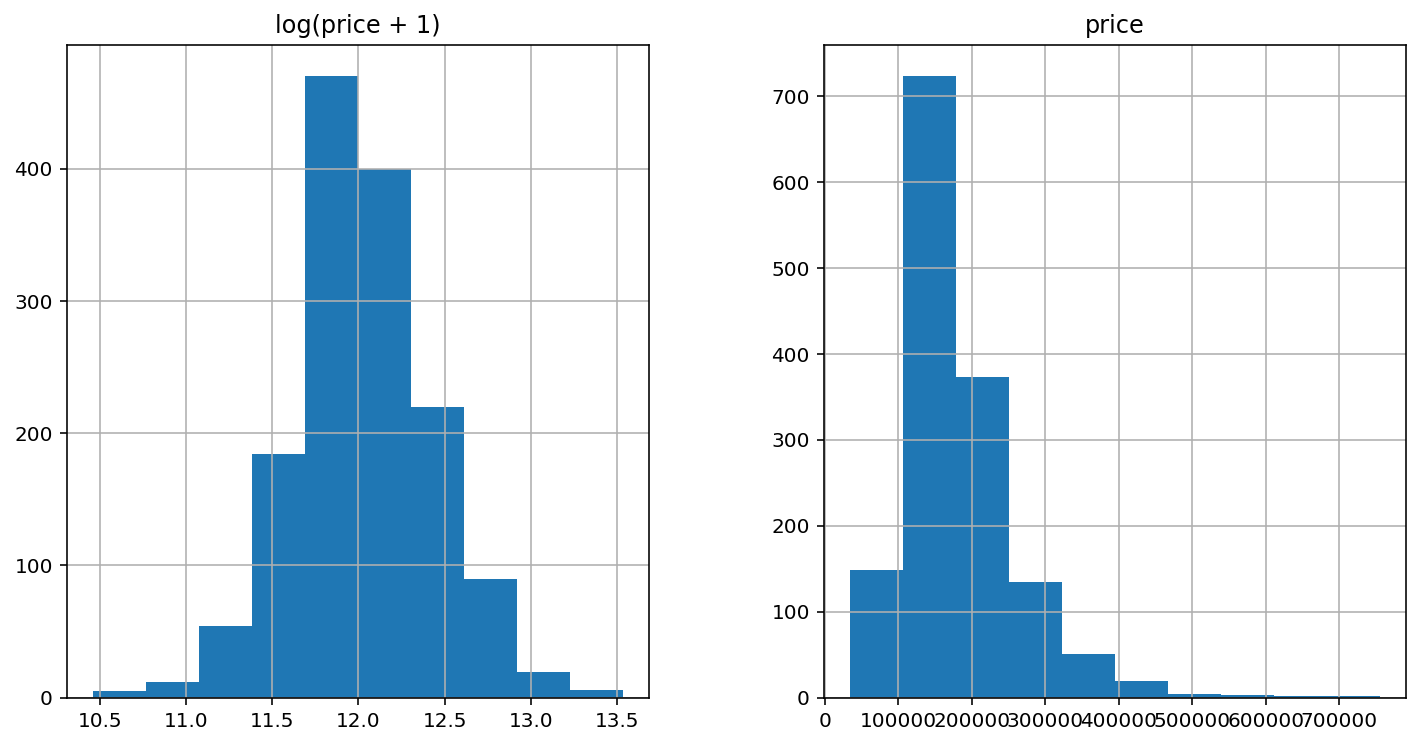

In [121]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [122]:
#filling NA's with the mean of the column:
all_data = all_data.replace(0,all_data.mean())
from numpy import inf
all_data = all_data.replace(-inf , 0)
all_data = all_data.replace(inf , 0)

In [130]:
all_data['MiscFeature'].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [168]:
X_train_tree = all_data[:train.shape[0]]

In [103]:
all_data = pd.get_dummies(all_data)

In [104]:
all_data

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,6.753438,6.751101,3.0,3.000000,6.561031,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
1,7.141245,2.829584,3.0,3.000000,6.886532,0.680974,5.000000,1.000000,0.429599,0.693147,...,0,0,0,0,0,0,0,0,0,1
2,6.825460,6.765039,3.0,3.000000,6.188264,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
3,6.869014,6.629363,3.0,4.000000,5.379897,0.680974,5.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
4,7.044033,6.960348,4.0,3.000000,6.486161,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
5,6.680855,6.340359,1.0,3.000000,6.597146,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
6,7.435438,2.829584,3.0,3.000000,7.222566,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
7,7.010312,6.891626,3.0,3.000000,6.756932,3.496508,5.000000,4.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1
8,6.930495,6.624065,2.0,3.000000,4.226981,0.680974,1.000000,1.000000,0.429599,0.042111,...,0,0,0,0,0,0,0,0,0,1
9,6.982863,2.829584,2.0,3.000000,6.747587,0.680974,6.000000,1.000000,1.000000,0.042111,...,0,0,0,0,0,0,0,0,0,1


In [43]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = np.log1p(train["SalePrice"])

In [44]:
# X_train.isnull().sum()
# np.isfinite(X_train).sum()

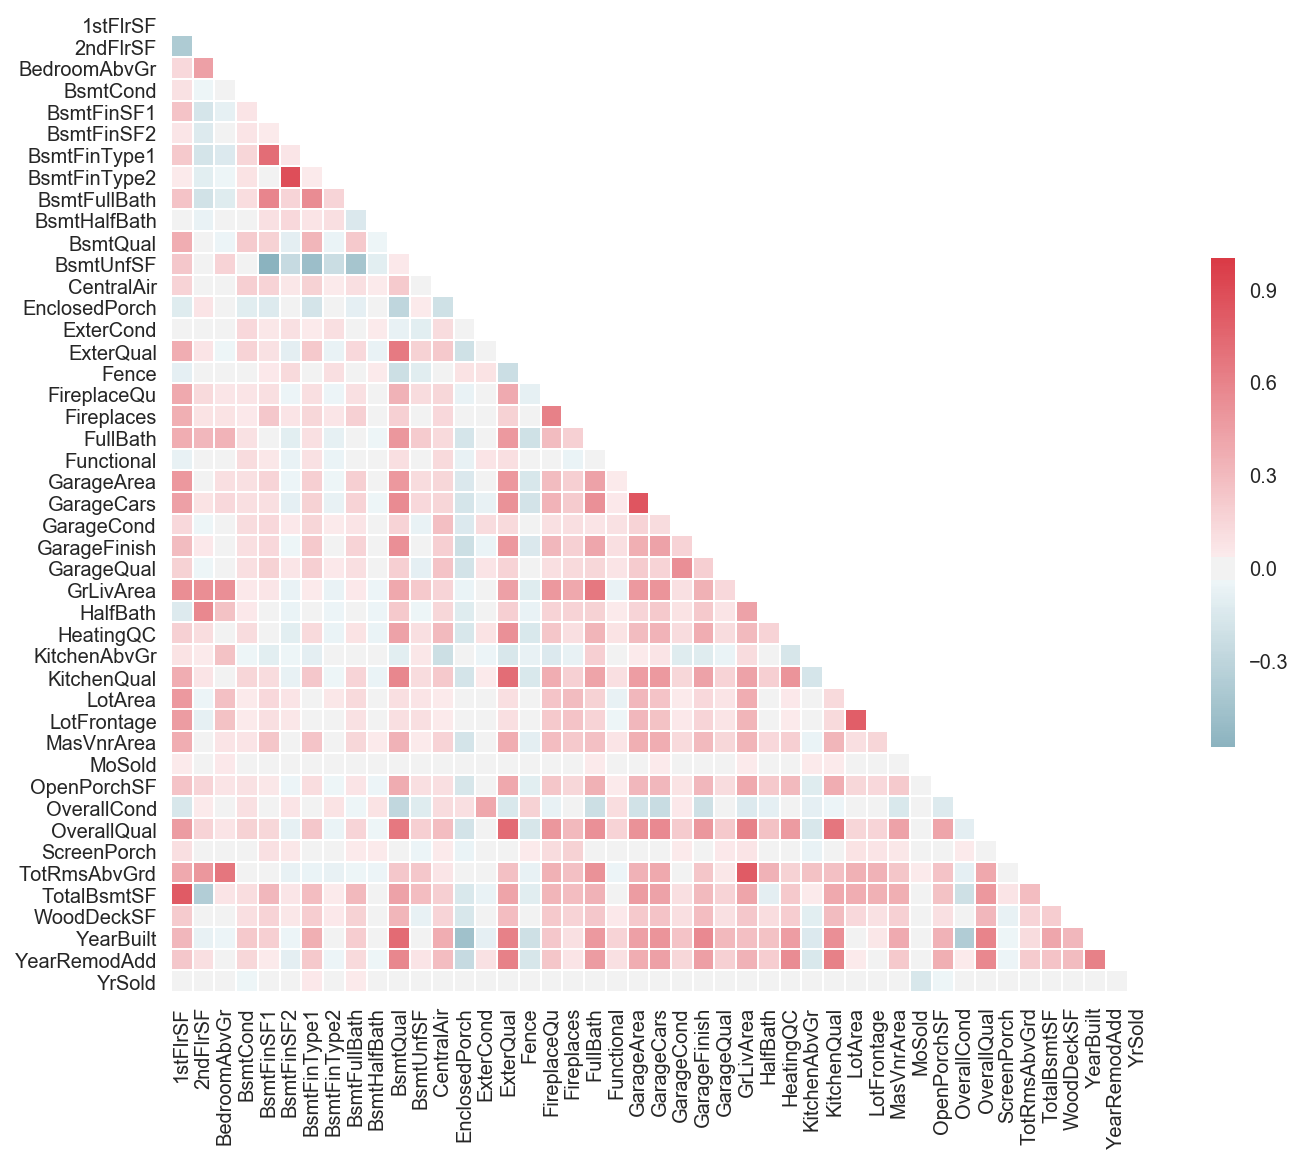

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# # Generate a large random dataset
# rs = np.random.RandomState(33)
# d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                  columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = all_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## ElasticNet

In [66]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)

In [67]:
from sklearn.model_selection import GridSearchCV
grid_el = {'alpha': [0.01],
           'l1_ratio':[0.02],
          'fit_intercept':[True],
          'normalize':[False]}

grid_search_E = GridSearchCV(estimator = regr, param_grid = grid_el, cv = 10, n_jobs = -1, 
                           verbose = 2, scoring = 'neg_mean_squared_error')

In [910]:
grid_search_E.fit(X_train, y)
grid_search_E.best_params_
# {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.02, 'normalize': False}

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


{'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.02, 'normalize': False}

In [911]:
from math import sqrt
sqrt(-grid_search_E.best_score_) #skew : 0.1325324059474199

0.12556617381222593

## Lasso

In [229]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()


NameError: name 'rmse_cv' is not defined

In [1011]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

## Random Forest

In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 0)
param_grid = {'n_estimators': [3000],
               'max_features': ['sqrt'],
               'max_depth': [21],
#                'min_samples_split': [2],
#                'min_samples_leaf': [1],
               'bootstrap' : [False]
               }

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

In [987]:
grid_search.fit(X_train, y)
grid_search.best_params_

# {'bootstrap': False,
#  'max_depth': 21,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 1000}

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


{'bootstrap': False,
 'max_depth': 21,
 'max_features': 'sqrt',
 'n_estimators': 3000}

In [988]:
sqrt(-grid_search.best_score_) #skew :0.1389821283984828

0.13621974413337026

## Graident Boosting

In [169]:
#gbm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
params = {'max_features': ['sqrt'],
          'min_samples_split': [10],#
          'min_samples_leaf': [2],
          'max_depth': [4],
          'n_estimators':[500],
          'learning_rate':[0.04],
          'subsample':[0.7],
          
          }
gbm = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator = gbm, param_grid = params,
                           cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

In [172]:
grid_search.fit(X_train, y)
print(grid_search.best_params_)
sqrt(-grid_search.best_score_)
# {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 3000, 'subsample': 0.7}
# 0.11574630876794141

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


{'learning_rate': 0.04, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.7}


0.11896335380279835

In [161]:
gb = GradientBoostingRegressor(learning_rate = 0.04, max_features='sqrt',n_estimators=500, max_depth=4,subsample=0.7,min_samples_split = 10,min_samples_leaf =2)

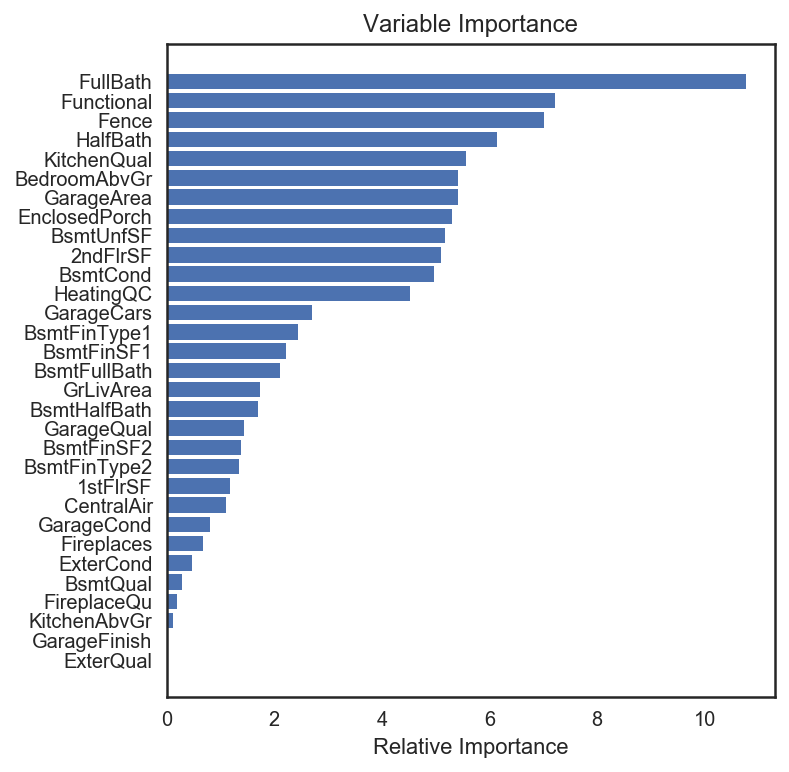

In [203]:
gb = GradientBoostingRegressor(learning_rate = 0.04, max_features='sqrt',n_estimators=10000, max_depth=4,subsample=0.7,min_samples_split = 10,min_samples_leaf =2)
gb.fit(X_train,y)
feature_importance = gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance = feature_importance[194:,]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos,feature_importance[sorted_idx] , align='center')
plt.yticks(pos,X_train.columns[sorted_idx]  )
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [197]:
feature_importance[sorted_idx][194:]

array([  18.04478423,   18.25651201,   18.86301945,   20.74557356,
         20.78122259,   21.15039884,   21.89035184,   22.28896506,
         22.75717289,   23.4984989 ,   25.1196471 ,   25.72733887,
         26.54670883,   26.82197981,   29.574074  ,   33.80409414,
         34.16984397,   36.33326664,   38.69267879,   38.91861534,
         46.69792334,   50.25339755,   51.6652884 ,   53.51265976,
         53.98289345,   54.05337877,   61.98086288,   63.76812548,
         67.67571045,   75.04270587,  100.        ])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = 1 / (1.0 + np.exp(-(np.sin(3 * x1) - 4 * x2 + x3)))
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_splits=3):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

## Xgboosting

In [696]:
score_xgb =[]

In [212]:
import xgboost as xgb
param_xgb = {
     'colsample_bytree':[0.31], #
             'gamma':[0.01], #
             'learning_rate':[0.04], #0.04
             'max_depth':[3], #
             'min_child_weight':[0.25],#
             'n_estimators':[1000],
             'reg_alpha':[0.04], #1
             'reg_lambda':[0.29],#
              'subsample':[0.595], #0.6
              'silent':[1],
              'random_state':[7], #
              'nthread':[-1],
                            }#
xgb1 = xgb.XGBRegressor()
grid_xgb = GridSearchCV(estimator = xgb1, param_grid = param_xgb,cv = 3, n_jobs = -1, verbose = 2,scoring = 'neg_mean_squared_error')

In [30]:
grid_xgb.fit(X_train, y)
print(grid_xgb.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


{'colsample_bytree': 0.31, 'gamma': 0.01, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 0.25, 'n_estimators': 1000, 'nthread': -1, 'random_state': 7, 'reg_alpha': 0.04, 'reg_lambda': 0.29, 'silent': 1, 'subsample': 0.595}


In [27]:
xgb1.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [ ]:
sqrt(-grid_xgb.best_score_)

## Multivariate Adaptive Regression Splines

In [31]:
from pyearth import Earth
earth = Earth()

ModuleNotFoundError: No module named 'pyearth'

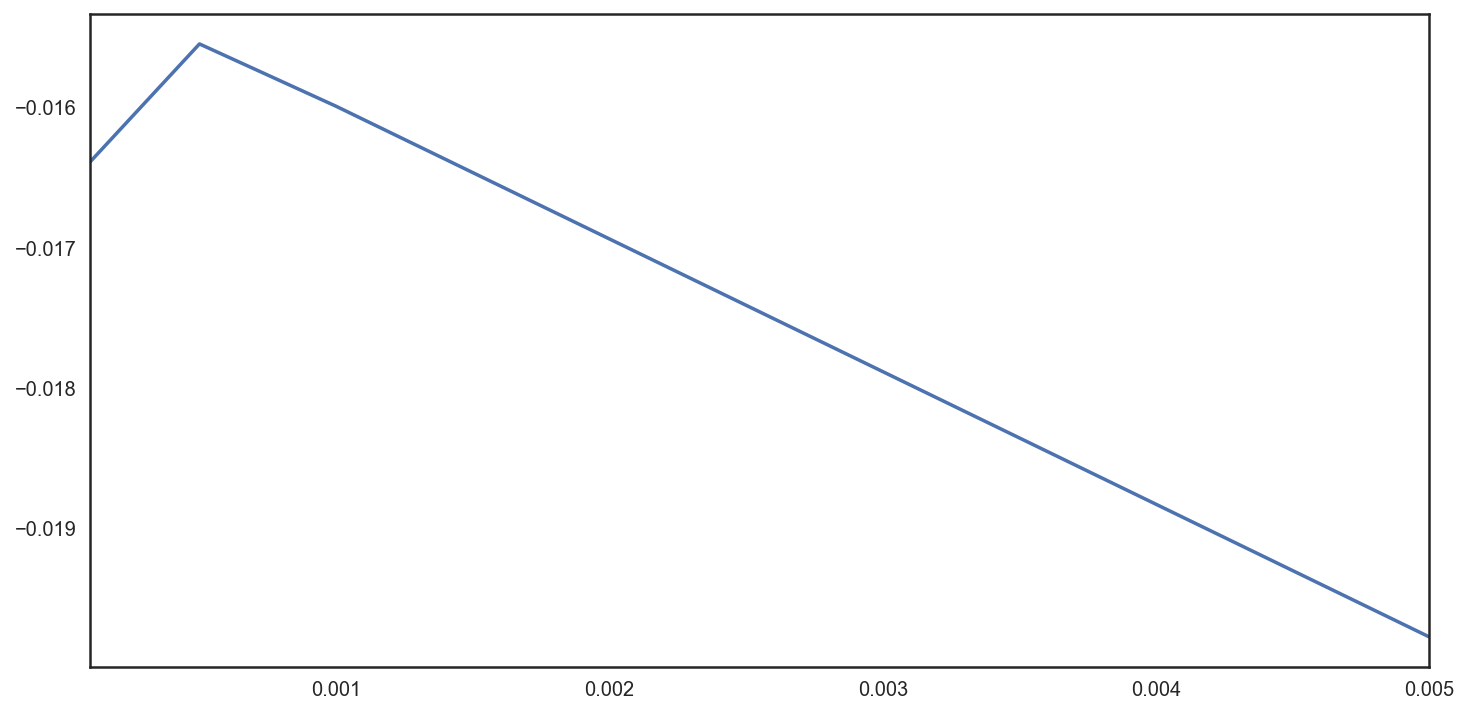

In [257]:
from sklearn.linear_model import Lasso
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

## Ridge

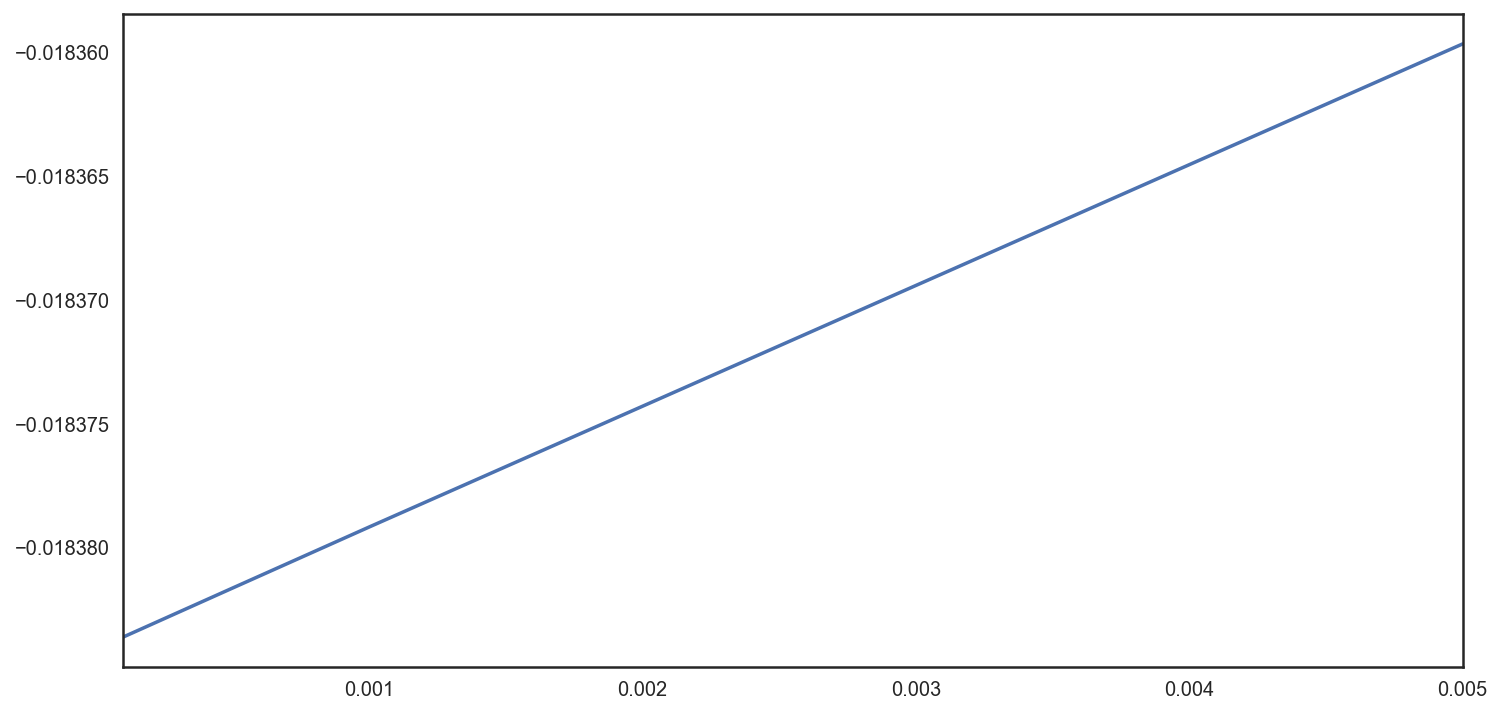

In [258]:
from sklearn.linear_model import Ridge
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_ridge = [rmse_cv(Ridge(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_ridge, index = alphas).plot()

In [250]:
model_ridge = Ridge(alpha=0.1e-4, max_iter=50000).fit(X_train, y)

## Stacking

In [68]:
from stacking import stacking_regression
from sklearn.metrics import mean_squared_error

In [69]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [267]:
from sklearn import linear_model
models = [ 
    # linear model, ElasticNet = lasso + ridge
    ElasticNet(random_state=0,alpha=0.01,fit_intercept=True,l1_ratio=0.02,normalize=False), 
    #random forest
    RandomForestRegressor(random_state = 0,n_estimators=3000,max_features='sqrt',max_depth=21,min_samples_split=2,
                         min_samples_leaf=1,bootstrap=False),

    
    #Lasso
    
    linear_model.Lasso(alpha = 0.0005),
    
    # gbr model
    GradientBoostingRegressor(learning_rate = 0.04, max_features='sqrt',n_estimators=500, max_depth=4,subsample=0.7,min_samples_split = 10,min_samples_leaf =2),
    
    # xgb

    xgb.XGBRegressor(random_state = 7, learning_rate = 0.0275 ,gamma=0.01,reg_alpha=0.04,reg_lambda=0.29,subsample=0.595,n_estimators =3000, max_depth = 3)]
from sklearn.linear_model import ElasticNet, LinearRegression as lr
meta_model = lr(normalize=True)

In [268]:
# stack with four
final_predictionall = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                       verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_predictionall
sub.to_csv('submission_four.csv',index=False)

metric: [rmsle]

model 0: [ElasticNet]
    ----


NameError: name 'price_scale' is not defined

In [263]:
# stack with three
%%time
final_prediction = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                       verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction
sub.to_csv('submission_3w.csv',index=False)

SyntaxError: invalid syntax (<ipython-input-263-d02861b254d0>, line 2)

In [999]:
# stack with boosting

final_prediction1 = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                        verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction1
sub.to_csv('submission_b.csv',index=False)

metric: [rmsle]

model 0: [GradientBoostingRegressor]
    ----
    MEAN:   [193000.51015524]

model 1: [XGBRegressor]
    ----
    MEAN:   [194360.54295107]



In [216]:
#random forest 
final_prediction2 = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, verbose=1,
                                        transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction2
sub.to_csv('submission_rf.csv',index=False)

metric: [rmsle]

model 0: [RandomForestRegressor]
    ----
    MEAN:   [187903.22325780]

